In [1]:
import numpy as np
import gdal
import matplotlib.pyplot as plt
import os
import pandas as pd
import datetime
import bisect
import functools
import itertools
import pickle as pkl
import time
from IPython.display import clear_output
%matplotlib inline
from PIL import Image
import sklearn

Load images from disk

In [2]:
# compose band and mask images into one image
combined = {}
image_dir = "2014/images/"
mask_dir = "2014/masks/"
for fn in os.listdir(image_dir):
    raw_img = gdal.Open(image_dir + fn)
    arr_img = raw_img.ReadAsArray()
    raw_msk = gdal.Open(mask_dir + fn)
    arr_msk = raw_msk.ReadAsArray()
    combined[fn.split('.')[0]] = np.concatenate((arr_img, arr_msk), axis=0)

Combine pixel bands and masks into a single image

In [3]:
combined_new = {}
image_dir = "2015/images/"
mask_dir = "2015/masks/"
for fn in os.listdir(image_dir):
    raw_img = gdal.Open(image_dir + fn)
    arr_img = raw_img.ReadAsArray()
    raw_msk = gdal.Open(mask_dir + fn)
    arr_msk = raw_msk.ReadAsArray()
    combined_new[fn.split('.')[0]] = np.concatenate((arr_img, arr_msk), axis=0)

Read image metadata

In [4]:
# use image names to look up metadata from csv export
table = pd.read_csv('2014/tables/LC8_SR.csv')
time_start = table[['system:index', 'system:time_start']]
table_new = pd.read_csv('2015/tables/LC8_SR.csv')
time_start_new = table_new[['system:index', 'system:time_start']]

Get timestamps for training and prediction images

In [5]:
# compose all data into a single data frame
ds = {}
for k, v in combined.items():
    ts = time_start[time_start['system:index'] == k]['system:time_start'].iloc[0]
    ds[ts] = v
    
ds_new = {}
for k, v in combined_new.items():
    ts = time_start_new[time_start_new['system:index'] == k]['system:time_start'].iloc[0]
    ds_new[ts] = v

Functions for running linear interpolation:

In [6]:
def get_boolean_mask(image, level=1):
    cfmask = image[3, :, :]
    cfmask_conf = image[4, :, :]
    return (cfmask == 0) & (cfmask_conf <= level)

In [7]:
def zigzag_integer_pairs(max_x, max_y):
    total = 0
    x = 0
    while total <= max_x + max_y:
        if total - x <= max_y:
            yield (x, total - x)
        if x <= min(max_x - 1, total - 1):
            x += 1
        else:
            total += 1
            x = 0

In [8]:
def interpolate(timestamp, dataset):
    times = list(dataset.keys())
    times.sort()
    pos = bisect.bisect(times, timestamp)
    n_times = len(times)
    dims = dataset[times[0]].shape
    interpolated = np.zeros((3, dims[1], dims[2]))
    times_before = times[:pos]
    times_before.reverse()
    times_after = times[pos:]
    unfilled = np.ones(dims[1:], dtype=bool)
    for pair in zigzag_integer_pairs(len(times_before) - 1, len(times_after) - 1):
        before = times_before[pair[0]]
        after = times_after[pair[1]]
        alpha = 1.0 * (timestamp - before) / (after - before)
        mask_before = get_boolean_mask(dataset[before])
        mask_after = get_boolean_mask(dataset[after])
        common_unmasked = mask_before & mask_after
        valid = common_unmasked & unfilled
#         fitted = dataset[before][:3, :, :] * alpha + dataset[after][:3, :, :] * (1 - alpha)
        fitted = np.zeros((3, dims[1], dims[2]))
        fitted[:, valid] = dataset[before][:3, valid] * alpha + dataset[after][:3, valid] * (1 - alpha)
        unfilled = unfilled ^ valid
        interpolated[:, valid] = fitted[:, valid]
    # todo: deal with timestamps before the first image or after the last
    # todo: deal with only having masked pixels on one side
    # the above two can be achieved with one-sided value filling
    # interpolate at existing time - remove cloud (should be working already)
    times.sort(key=lambda t: abs(t - timestamp))
    for ts in times:
        mask = get_boolean_mask(dataset[ts])
        valid = mask & unfilled
        unfilled = unfilled ^ valid
        interpolated[:, valid] = dataset[ts][:3, valid]
    return interpolated

In [9]:
def interpolate_images(timestamps, dataset):
    return {ts: interpolate(ts, dataset) for ts in timestamps}

Obtain lagged timestamps of the new year for interpolating the training data (in the previous year)

In [10]:
times = list(ds_new.keys())
times.sort()
print(times)
times_to_fit = []
for t in times:
    dt = datetime.datetime.fromtimestamp(t/1000)
    dt = dt.replace(year=dt.year - 1)
    times_to_fit += [int(dt.timestamp() * 1000)]
print(times_to_fit)

[1426205354132, 1426810523472, 1427587746370, 1428192911630, 1429575310943, 1430352533188, 1430957695975, 1431734919028, 1432340092546, 1433117325195, 1433722502125, 1434499736147, 1435104908414, 1435882143244, 1436487319228, 1437264552573, 1437869725294, 1438646955592, 1439252129269, 1440029363213, 1440634536577, 1441411768125, 1442016943362, 1442794176672, 1443399349500, 1444176579436, 1444781749463, 1445558982533, 1446164155488, 1446941385063, 1447546555861, 1448323787335, 1448928958023, 1449706184998, 1450311357239, 1451088586307, 1451693755106, 1452470982577, 1453076154238, 1453853382683]
[1394669354132, 1395274523472, 1396051746370, 1396653311630, 1398039310943, 1398816533188, 1399421695975, 1400198919028, 1400804092546, 1401581325195, 1402186502125, 1402963736147, 1403568908414, 1404346143244, 1404951319228, 1405728552573, 1406333725294, 1407110955592, 1407716129269, 1408493363213, 1409098536577, 1409875768125, 1410480943362, 1411258176672, 1411863349500, 1412640579436, 14132457

In [11]:
fitted_images = interpolate_images(times_to_fit, ds)

Convert interpolated images to the format of training set needed

In [11]:
def convert_to_dataframe(image):
    frame = pd.Panel(image).to_frame()
    return frame

In [12]:
def make_set(images):
    times = list(images.keys())
    times.sort()
    res = pd.concat([convert_to_dataframe(i) for i in images.values()], axis=1, keys=images.keys())
#     res = pd.concat(list(map(convert_to_dataframe, images.values())), axis=0)
    return res.reset_index()

In [33]:
train = make_set(fitted_images)

In [19]:
to_predict = make_set(ds_new)
to_predict.columns = [c for c in to_predict.columns]
to_predict = to_predict.rename(columns={('major', ''): 'x', ('minor', ''): 'y'})

In [20]:
to_predict.head(10)

,x,y,"(1442794176672, 0)","(1442794176672, 1)","(1442794176672, 2)","(1442794176672, 3)","(1442794176672, 4)","(1432340092546, 0)","(1432340092546, 1)","(1432340092546, 2)",...,"(1435104908414, 0)","(1435104908414, 1)","(1435104908414, 2)","(1435104908414, 3)","(1435104908414, 4)","(1439252129269, 0)","(1439252129269, 1)","(1439252129269, 2)","(1439252129269, 3)","(1439252129269, 4)"
0,0,0,5349,3927,4028,4,3,2726,193,416,...,6282,410,688,0,1,2248,325,394,4,1
1,0,1,5349,3927,4028,4,3,2508,154,364,...,7244,416,856,0,1,2385,362,461,4,1
2,0,2,5330,3898,4032,4,3,1714,106,301,...,7216,405,867,0,1,2386,372,465,4,1
3,0,3,5446,4068,4214,4,3,1714,106,301,...,7216,405,867,0,1,2386,372,465,4,1
4,0,4,5666,4262,4372,4,3,1516,126,279,...,7079,369,862,0,1,2302,355,459,4,1
5,0,5,5666,4262,4372,4,3,1104,128,234,...,5252,306,672,0,1,1978,348,420,4,1
6,0,6,5791,4457,4539,4,3,673,77,112,...,2656,202,272,0,1,1439,318,314,4,1
7,0,7,5955,4714,4789,4,3,869,94,145,...,3030,390,421,0,1,1288,342,324,4,1
8,0,8,6100,4875,4935,4,3,869,94,145,...,3030,390,421,0,1,1288,342,324,4,1
9,0,9,6166,4933,4996,4,3,1037,207,228,...,4392,694,759,0,1,1579,372,367,2,1


Load labels

In [2]:
label_image = Image.open('labels/labels.png')

In [3]:
labels = np.array(label_image)

In [5]:
pix_array = labels.reshape(labels.shape[0] * labels.shape[1], labels.shape[2])

In [6]:
# unique colours in the label pic
label_colours = np.vstack({tuple(row) for row in pix_array})

In [7]:
label_map = {tuple(row):i for row, i in zip(label_colours, range(label_colours.shape[0]))}

In [8]:
label_map

{(0, 0, 0): 3,
 (0, 156, 255): 4,
 (0, 255, 102): 2,
 (171, 239, 170): 6,
 (246, 255, 0): 0,
 (252, 0, 255): 1,
 (255, 156, 0): 5}

In [9]:
label_converted = np.apply_along_axis(lambda x: label_map[tuple(x)], 2, labels)

In [50]:
label_converted.shape

(973, 1022)

In [51]:
df = pd.DataFrame(label_converted)

In [52]:
df['x'] = df.index

In [53]:
label_set = pd.melt(df, id_vars='x')
label_set.head(10)

,x,variable,value
0,0,0,3
1,1,0,3
2,2,0,3
3,3,0,3
4,4,0,3
5,5,0,3
6,6,0,3
7,7,0,5
8,8,0,3
9,9,0,5


Merge label data and training data into a single training set

In [54]:
train_labelled = pd.merge(train, label_set, left_on=['major', 'minor'], right_on=['x', 'variable'], copy=False)
train_labelled = train_labelled.drop(['x', 'variable'], axis=1).rename(columns={('major', ''): 'x', ('minor', ''): 'y', 'value': 'label'})

E:\Anaconda3\envs\earth_engine\lib\site-packages\pandas\tools\merge.py:489: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


In [55]:
train_labelled.head(10)

,x,y,"(1409098536577, 0)","(1409098536577, 1)","(1409098536577, 2)","(1396051746370, 0)","(1396051746370, 1)","(1396051746370, 2)","(1419552586307, 0)","(1419552586307, 1)",...,"(1404951319228, 0)","(1404951319228, 1)","(1404951319228, 2)","(1405728552573, 0)","(1405728552573, 1)","(1405728552573, 2)","(1403568908414, 0)","(1403568908414, 1)","(1403568908414, 2)",label
0,0,0,5143.424218,530.809178,746.098145,3683.0,300.0,520.0,2500.376913,1160.233820,...,5317.222064,352.653802,679.980505,4677.809913,680.488332,763.650098,3879.824404,297.802890,531.351733,3
1,0,1,5143.424218,530.809178,746.098145,3683.0,300.0,520.0,2565.214060,1302.679068,...,5644.018700,371.994828,724.998409,4677.809913,680.488332,763.650098,4059.255023,308.422254,556.069216,3
2,0,2,4976.037107,517.691136,769.753608,3438.0,349.0,552.0,2565.808824,1271.820020,...,5327.003581,407.321928,772.321132,4624.998050,601.550466,735.624810,3787.157337,349.183092,581.111702,3
3,0,3,4611.802366,488.568970,704.951958,3089.0,429.0,564.0,2530.192160,1271.311211,...,5024.397124,405.322326,718.998409,4352.911062,545.612817,686.424897,3502.056609,414.535695,590.914593,3
4,0,4,4375.623913,459.270413,650.226495,2897.0,473.0,564.0,2438.469781,1197.822161,...,4678.366091,395.991645,656.663749,4149.398743,502.662741,636.087421,3253.297943,451.211996,578.281213,3
5,0,5,4375.623913,459.270413,650.226495,2897.0,473.0,564.0,2348.581918,1137.896919,...,4372.577811,375.316756,606.643856,4149.398743,502.662741,636.087421,3085.402150,439.860263,550.817342,3
6,0,6,2694.832482,302.969795,396.120104,1947.0,327.0,387.0,1788.909764,568.907132,...,2145.604069,215.651017,317.319939,3097.064735,352.212774,442.437757,1925.761274,292.212431,361.916332,3
7,0,7,2015.035673,224.643094,277.420722,1749.0,206.0,254.0,2013.369999,432.951917,...,2062.738149,194.346595,270.679664,2150.575753,289.975363,317.887725,1872.221231,216.070086,269.013582,3
8,0,8,2824.599175,478.667115,499.122165,2246.0,607.0,508.0,2096.305945,666.495472,...,2685.280948,357.647437,427.315164,2832.400043,553.262914,525.937649,2278.224274,543.650006,476.508095,3
9,0,9,3012.687730,535.228556,600.631442,2311.0,777.0,694.0,2432.134529,1319.718096,...,3184.021485,561.664147,637.991247,2892.261831,501.587313,539.687161,2490.613711,735.254917,675.690753,3


Train and test a random forest classifier

In [56]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [57]:
clf = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)

In [58]:
X = train_labelled.ix[train_labelled.ix[:, 'label'] != 3, 2:-1]
y = train_labelled.ix[train_labelled.ix[:, 'label'] != 3, 'label']

In [59]:
cross_val_score(clf, X, y, cv=10, scoring='accuracy')

array([ 0.99191919,  0.98565367,  0.98706809,  0.983431  ,  0.99131138,
        0.99696908,  0.99595715,  0.99110572,  0.99251921,  0.9947411 ])

In [77]:
from collections import Counter

In [78]:
Counter(y)

Counter({0: 17706, 1: 331, 2: 17939, 4: 1939, 5: 8096, 6: 3468})

In [79]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [81]:
model = clf.fit(X_train, y_train)

In [82]:
pred = clf.predict(X_test)

In [83]:
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      5778
          1       0.99      0.91      0.95       123
          2       1.00      1.00      1.00      5957
          4       1.00      0.99      1.00       653
          5       0.99      1.00      1.00      2688
          6       1.00      0.98      0.99      1130

avg / total       1.00      1.00      1.00     16329



Obtain the formatted data for the new year

In [ ]:
# run prediction on the new images
new_no_cloud = interpolate_images(dataset=ds_new, timestamps=list(ds_new.keys()))
new_set = make_set(new_no_cloud)

In [62]:
new_set.head()

major minor 1446164155488                 1427587746370                \
                          0       1       2             0      1      2   
0     0     0        2830.0  1381.0  1058.0        2904.0  795.0  748.0   
1     0     1        2830.0  1381.0  1058.0        2904.0  795.0  748.0   
2     0     2        2744.0  1483.0  1105.0        3073.0  819.0  804.0   
3     0     3        2627.0  1353.0  1018.0        3071.0  842.0  809.0   
4     0     4        2477.0  1242.0   942.0        2824.0  855.0  776.0   

  1451088586307          ...   1453076154238 1436487319228              \
              0       1  ...               2             0           1   
0        2296.0  1105.0  ...           609.0   5989.769693  373.291267   
1        2314.0  1417.0  ...           609.0   6605.555954  377.131930   
2        2239.0  1389.0  ...           944.0   6674.366241  369.730825   
3        2239.0  1389.0  ...           987.0   6604.907559  362.892924   
4        2150.0  1299.0  ...           823.0   6385.492855  341.288505   

              1437264552573               1435104908414                
            2             0      1      2             0      1      2  
0  646.972592        5697.0  529.0  726.0        5470.0  308.0  574.0  
1  754.511149        5697.0  529.0  726.0        5470.0  308.0  574.0  
2  805.818778        5494.0  407.0  684.0        5711.0  307.0  697.0  
3  793.582534        5297.0  362.0  647.0        5518.0  288.0  663.0  
4  774.546842        4988.0  406.0  638.0        5152.0  292.0  619.0  

[5 rows x 122 columns]

In [71]:
new_set.columns = [c for c in new_set.columns]

In [89]:
new_set = new_set.rename(columns={('major', ''): 'x', ('minor', ''): 'y'})
new_set.head()

,x,y,"(1446164155488, 0)","(1446164155488, 1)","(1446164155488, 2)","(1427587746370, 0)","(1427587746370, 1)","(1427587746370, 2)","(1451088586307, 0)","(1451088586307, 1)",...,"(1453076154238, 2)","(1436487319228, 0)","(1436487319228, 1)","(1436487319228, 2)","(1437264552573, 0)","(1437264552573, 1)","(1437264552573, 2)","(1435104908414, 0)","(1435104908414, 1)","(1435104908414, 2)"
0,0,0,2830.0,1381.0,1058.0,2904.0,795.0,748.0,2296.0,1105.0,...,609.0,5989.769693,373.291267,646.972592,5697.0,529.0,726.0,5470.0,308.0,574.0
1,0,1,2830.0,1381.0,1058.0,2904.0,795.0,748.0,2314.0,1417.0,...,609.0,6605.555954,377.131930,754.511149,5697.0,529.0,726.0,5470.0,308.0,574.0
2,0,2,2744.0,1483.0,1105.0,3073.0,819.0,804.0,2239.0,1389.0,...,944.0,6674.366241,369.730825,805.818778,5494.0,407.0,684.0,5711.0,307.0,697.0
3,0,3,2627.0,1353.0,1018.0,3071.0,842.0,809.0,2239.0,1389.0,...,987.0,6604.907559,362.892924,793.582534,5297.0,362.0,647.0,5518.0,288.0,663.0
4,0,4,2477.0,1242.0,942.0,2824.0,855.0,776.0,2150.0,1299.0,...,823.0,6385.492855,341.288505,774.546842,4988.0,406.0,638.0,5152.0,292.0,619.0


In [75]:
X_new = new_set.iloc[:, 2:]

Train model on the data from previous year

In [84]:
model_full = clf.fit(X, y)

Predict labels for the new year

In [85]:
pred_new = model_full.predict(X_new)

In [92]:
cls_table = new_set.iloc[:, :2]
cls_table['pred_label'] = pred_new

In [93]:
cls_table.head()

,x,y,pred_label
0,0,0,5
1,0,1,5
2,0,2,5
3,0,3,5
4,0,4,6


In [94]:
cls_map = cls_table.pivot(index='x', columns='y', values='pred_label')

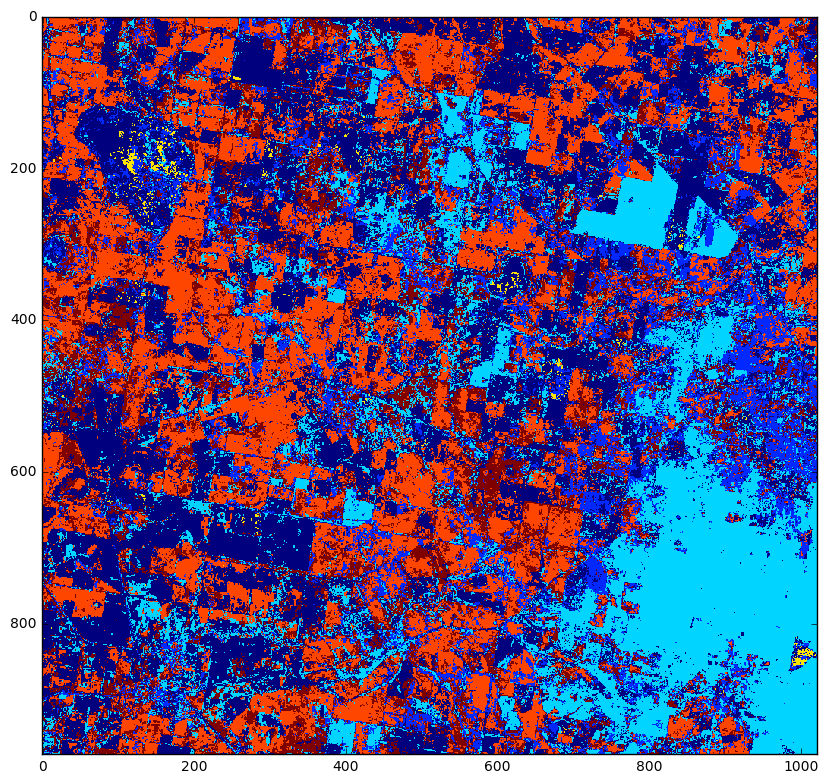

In [96]:
plt.figure(figsize=(10, 10))
plt.imshow(cls_map, interpolation='nearest')
plt.show()

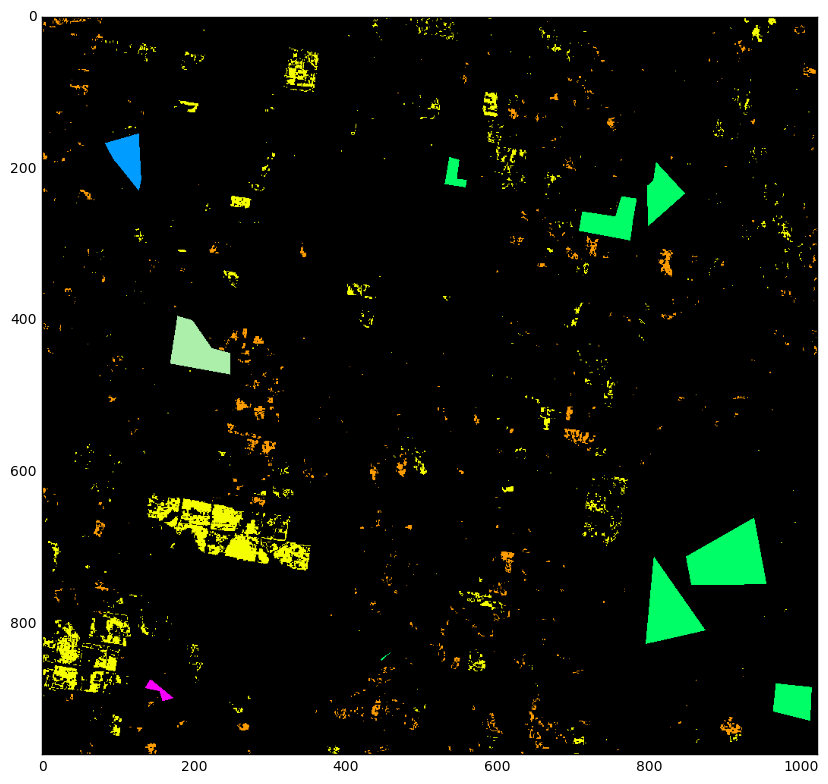

In [97]:
plt.figure(figsize=(10, 10))
plt.imshow(label_image)
plt.show()